AP: Note that I have converted previous step cells to markdown cells to reduce system resource usage (just faster to rerun code so slower cells don't slow me down) (Mostly just the cells that made plots)

# August Perez Capstone Two Project:
## Asthma prediction model

### The goal is to build a model with at least 90% sensitivity (recall) (focusing on reducing false negatives)

Data source: Asthma Disease Dataset (https://www.kaggle.com/datasets/rabieelkharoua/asthma-disease-dataset?resource=download)

#### About the dataset: (from the kaggle description)
- health information for 2,392 patients
  - includes demographic details, lifestyle factors, environmental and allergy factors, medical history, clinical measurements, symptoms, and a diagnosis indicator


Column Info: (from Kaggle description)
Patient ID

    PatientID: A unique identifier assigned to each patient (5034 to 7425).

Demographic Details

    Age: The age of the patients ranges from 5 to 80 years.
    Gender: Gender of the patients, where 0 represents Male and 1 represents Female.
    Ethnicity: The ethnicity of the patients, coded as follows:
    0: Caucasian
    1: African American
    2: Asian
    3: Other
    EducationLevel: The education level of the patients, coded as follows:
    0: None
    1: High School
    2: Bachelor's
    3: Higher

Lifestyle Factors

    BMI: Body Mass Index of the patients, ranging from 15 to 40.
    Smoking: Smoking status, where 0 indicates No and 1 indicates Yes.
    PhysicalActivity: Weekly physical activity in hours, ranging from 0 to 10.
    DietQuality: Diet quality score, ranging from 0 to 10.
    SleepQuality: Sleep quality score, ranging from 4 to 10.

Environmental and Allergy Factors

    PollutionExposure: Exposure to pollution, score from 0 to 10.
    PollenExposure: Exposure to pollen, score from 0 to 10.
    DustExposure: Exposure to dust, score from 0 to 10.
    PetAllergy: Pet allergy status, where 0 indicates No and 1 indicates Yes.

Medical History

    FamilyHistoryAsthma: Family history of asthma, where 0 indicates No and 1 indicates Yes.
    HistoryOfAllergies: History of allergies, where 0 indicates No and 1 indicates Yes.
    Eczema: Presence of eczema, where 0 indicates No and 1 indicates Yes.
    HayFever: Presence of hay fever, where 0 indicates No and 1 indicates Yes.
    GastroesophagealReflux: Presence of gastroesophageal reflux, where 0 indicates No and 1 indicates Yes.

Clinical Measurements

    LungFunctionFEV1: Forced Expiratory Volume in 1 second (FEV1), ranging from 1.0 to 4.0 liters.
    LungFunctionFVC: Forced Vital Capacity (FVC), ranging from 1.5 to 6.0 liters.

Symptoms

    Wheezing: Presence of wheezing, where 0 indicates No and 1 indicates Yes.
    ShortnessOfBreath: Presence of shortness of breath, where 0 indicates No and 1 indicates Yes.
    ChestTightness: Presence of chest tightness, where 0 indicates No and 1 indicates Yes.
    Coughing: Presence of coughing, where 0 indicates No and 1 indicates Yes.
    NighttimeSymptoms: Presence of nighttime symptoms, where 0 indicates No and 1 indicates Yes.
    ExerciseInduced: Presence of symptoms induced by exercise, where 0 indicates No and 1 indicates Yes.

Diagnosis Information

    Diagnosis: Diagnosis status for Asthma, where 0 indicates No and 1 indicates Yes.

Confidential Information

    DoctorInCharge: This column contains confidential information about the doctor in charge, with "Dr_Confid" as the value for all patients.


#### Imports:

In [1]:
%matplotlib inline

#data manipulation and math

import numpy as np
import scipy as sp
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#plotting and visualization

import matplotlib.pyplot as plt
import seaborn as sns

#modeling & pre-processing
import sklearn.model_selection
import sklearn.metrics
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier

In [2]:
plt.rcParams['figure.figsize'] = [8,8]

#### Set random seed for reproducability
Note that this should not be done for models used in real-world applications

In [3]:
np.random.seed(9)

#### Load the data into a pandas df

In [4]:
df_adhd = pd.read_csv('asthma_disease_data.csv')
df_adhd.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,PollenExposure,DustExposure,PetAllergy,FamilyHistoryAsthma,HistoryOfAllergies,Eczema,HayFever,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis,DoctorInCharge
0,5034,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,2.855578,0.974339,1,1,0,0,0,0,1.369051,4.941206,0,0,1,0,0,1,0,Dr_Confid
1,5035,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,1.969838,7.457665,6.584631,0,0,1,0,0,0,2.197767,1.702393,1,0,0,1,1,1,0,Dr_Confid
2,5036,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,1.448189,5.445799,0,1,1,0,1,0,1.698011,5.022553,1,1,1,0,1,1,0,Dr_Confid
3,5037,40,1,2,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,7.571845,3.965316,0,0,0,0,1,0,3.032037,2.300159,1,0,1,1,1,0,0,Dr_Confid
4,5038,61,0,0,3,19.283802,0,4.604493,3.127048,9.625799,0.980875,3.049807,8.260605,0,0,0,0,1,0,3.470589,3.067944,1,1,1,0,0,1,0,Dr_Confid


In [5]:
print('shape:', df_adhd.shape,'\n')
print('columns:\n','\n'.join(list(df_adhd.columns)))
print('\nnumber of cols:', len(df_adhd.columns))

shape: (2392, 29) 

columns:
 PatientID
Age
Gender
Ethnicity
EducationLevel
BMI
Smoking
PhysicalActivity
DietQuality
SleepQuality
PollutionExposure
PollenExposure
DustExposure
PetAllergy
FamilyHistoryAsthma
HistoryOfAllergies
Eczema
HayFever
GastroesophagealReflux
LungFunctionFEV1
LungFunctionFVC
Wheezing
ShortnessOfBreath
ChestTightness
Coughing
NighttimeSymptoms
ExerciseInduced
Diagnosis
DoctorInCharge

number of cols: 29


- AP: ~~Removing index location 476. lungfunctionfvc=0 when data is scaled. Removing from original df so that when data is split there isn't a mismatch of rows, and less code to write for me~~
    - ~~AP: Removing that row where lungfunctionfvc=0 (after normalization) (causing 'lungfunction' custom feature to compute an inf value) seems to cause NaN's to pop up in further iterations of the dataframe. Choosing to impute the mean of lungfunctionfvc in that row for now.~~
- AP: I will also look into creating those custom features before performing the scaling so I don't have to change data
    - Done, this was a correct choice as creating features using the scaled data a) caused the inf result from a calculation for row 476 & b) it would be better in this case to create features based on the original data rather than transformed data

~~#df_adhd.drop(476, inplace=True)~~

# Data Wrangling

In [6]:
df_adhd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               2392 non-null   int64  
 1   Age                     2392 non-null   int64  
 2   Gender                  2392 non-null   int64  
 3   Ethnicity               2392 non-null   int64  
 4   EducationLevel          2392 non-null   int64  
 5   BMI                     2392 non-null   float64
 6   Smoking                 2392 non-null   int64  
 7   PhysicalActivity        2392 non-null   float64
 8   DietQuality             2392 non-null   float64
 9   SleepQuality            2392 non-null   float64
 10  PollutionExposure       2392 non-null   float64
 11  PollenExposure          2392 non-null   float64
 12  DustExposure            2392 non-null   float64
 13  PetAllergy              2392 non-null   int64  
 14  FamilyHistoryAsthma     2392 non-null   

AP: No null values found, making my job here easier than expected.

In [7]:
#AP: Looking at col names to ensure they make sense
df_adhd.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,PollenExposure,DustExposure,PetAllergy,FamilyHistoryAsthma,HistoryOfAllergies,Eczema,HayFever,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis,DoctorInCharge
0,5034,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,2.855578,0.974339,1,1,0,0,0,0,1.369051,4.941206,0,0,1,0,0,1,0,Dr_Confid
1,5035,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,1.969838,7.457665,6.584631,0,0,1,0,0,0,2.197767,1.702393,1,0,0,1,1,1,0,Dr_Confid
2,5036,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,1.448189,5.445799,0,1,1,0,1,0,1.698011,5.022553,1,1,1,0,1,1,0,Dr_Confid
3,5037,40,1,2,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,7.571845,3.965316,0,0,0,0,1,0,3.032037,2.300159,1,0,1,1,1,0,0,Dr_Confid
4,5038,61,0,0,3,19.283802,0,4.604493,3.127048,9.625799,0.980875,3.049807,8.260605,0,0,0,0,1,0,3.470589,3.067944,1,1,1,0,0,1,0,Dr_Confid


##### AP: Col names to edit:
- Change all to lower case (mainly makes my typing easier/faster)

In [8]:
#AP: change col names to lower case
df_adhd.columns = df_adhd.columns.str.lower()
df_adhd.head()

,patientid,age,gender,ethnicity,educationlevel,bmi,smoking,physicalactivity,dietquality,sleepquality,pollutionexposure,pollenexposure,dustexposure,petallergy,familyhistoryasthma,historyofallergies,eczema,hayfever,gastroesophagealreflux,lungfunctionfev1,lungfunctionfvc,wheezing,shortnessofbreath,chesttightness,coughing,nighttimesymptoms,exerciseinduced,diagnosis,doctorincharge
0,5034,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,2.855578,0.974339,1,1,0,0,0,0,1.369051,4.941206,0,0,1,0,0,1,0,Dr_Confid
1,5035,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,1.969838,7.457665,6.584631,0,0,1,0,0,0,2.197767,1.702393,1,0,0,1,1,1,0,Dr_Confid
2,5036,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,1.448189,5.445799,0,1,1,0,1,0,1.698011,5.022553,1,1,1,0,1,1,0,Dr_Confid
3,5037,40,1,2,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,7.571845,3.965316,0,0,0,0,1,0,3.032037,2.300159,1,0,1,1,1,0,0,Dr_Confid
4,5038,61,0,0,3,19.283802,0,4.604493,3.127048,9.625799,0.980875,3.049807,8.260605,0,0,0,0,1,0,3.470589,3.067944,1,1,1,0,0,1,0,Dr_Confid


#### Check the data types, ensure they make sense for the column

In [9]:
df_adhd.dtypes

patientid                   int64
age                         int64
gender                      int64
ethnicity                   int64
educationlevel              int64
bmi                       float64
smoking                     int64
physicalactivity          float64
dietquality               float64
sleepquality              float64
pollutionexposure         float64
pollenexposure            float64
dustexposure              float64
petallergy                  int64
familyhistoryasthma         int64
historyofallergies          int64
eczema                      int64
hayfever                    int64
gastroesophagealreflux      int64
lungfunctionfev1          float64
lungfunctionfvc           float64
wheezing                    int64
shortnessofbreath           int64
chesttightness              int64
coughing                    int64
nighttimesymptoms           int64
exerciseinduced             int64
diagnosis                   int64
doctorincharge             object
dtype: object

##### AP: Data types check out. doctorincharge col has every value as "Dr_Confid" so object type makes sense.

#### Visualize the data
Detection of possible duplicates and outliers

#Code-Cell
#AP: histogram of all columns
df_adhd.hist(figsize=(8,8))
plt.tight_layout()
plt.show()

AP: Most of the data is categorical between 0 or 1 (yes or no)
Continuous values don't seem to have any specific distribution


In [10]:
#AP: Make list of cols that are non-categorical in nature
    #I did make another (almost same) list later on. this list is used in further steps due to those differences

non_cat_cols = ['age', 'bmi', 'physicalactivity', 'dietquality', 'sleepquality', 'pollutionexposure', 'pollenexposure', 'dustexposure', 'lungfunctionfev1', 'lungfunctionfvc']

#Code-cell
#AP: box & whisker plot to see potential outliers
df_adhd[non_cat_cols].boxplot(rot=34)
plt.tight_layout()
plt.show()

#Code-cell
#Boxplot without age & bmi so other columns can be inspected more closely

non_cat_cols_noagebmi = [element for element in non_cat_cols if element != 'age' and element != 'bmi']
df_adhd[non_cat_cols_noagebmi].boxplot(rot=35)
plt.tight_layout()
plt.show()

AP: No outliers seen, max & min's seem reasonable for non-categorical cols

#### A look at consistency in values within columns
ex. categorical values are within specified ranges, numerical values are within reasonable ranges for the metric measured

In [11]:
df_adhd.nunique(axis=0)

patientid                 2392
age                         75
gender                       2
ethnicity                    4
educationlevel               4
bmi                       2392
smoking                      2
physicalactivity          2392
dietquality               2392
sleepquality              2392
pollutionexposure         2392
pollenexposure            2392
dustexposure              2392
petallergy                   2
familyhistoryasthma          2
historyofallergies           2
eczema                       2
hayfever                     2
gastroesophagealreflux       2
lungfunctionfev1          2392
lungfunctionfvc           2392
wheezing                     2
shortnessofbreath            2
chesttightness               2
coughing                     2
nighttimesymptoms            2
exerciseinduced              2
diagnosis                    2
doctorincharge               1
dtype: int64

 AP: The count of unique values within each column is consistent with expectations

## Data Wrangling Conclusions:

- Data is tidy (each observation is a row, each variable is a col)
- No null values found, making my job here easier than expected.
- Data types for each col check out. (all but doctorincharge are numerical int or float) (doctorincharge col has every value as "Dr_Confid" so object type makes sense)
- Continuous values don't seem to have any specific distribution (flat). Most of the data is categorical (17 out of 29 cols) between 0 or 1 (yes or no).
- No outliers detected, max & min's seem reasonable for non-categorical cols
- The count of unique values within each column is consistent with expectations (as many unique values for cat cols as there are categories for that col; and for all but 'age' col, unique values equals sample count)

# EDA

The Data Wrangling performed above did change the dataset in that col names are now all lower case, no other changes were made.

EDA Major Tasks:

1. Form hypotheses/develop investigation themes to explore
2. Exploration of each individual variable
3. Assessment of the relationship between each variable and the target variable
4. Assessment of the interaction between variables
5. Exploration of data across many dimensions

Target Variable: 'diagnosis'

#code-cell
df_adhd.head()

## List of hypothesis' to consider

- Before fully investigating data: (just looking at rows and columns, plus the quick visualizations from data wrangling steps)
    - a diagnosis of asthma (1) occurs with low lung FEV & FVC
    - a diagnosis of asthma (1) occurs with >1 symptom being present
    - smoking has a high correlation with asthma diagnosis
    - increased bmi is correlated with asthma diagnosis
    - ethnicity does not affect asthma diagnosis
        - acknowledging the possibility of cultural differences that can occur within ethnicity groups that could affect Lifestyle & Environmental and Allergy Factors
- During EDA:
    - 

#### Drop unnecessary cols

cols  only for imformational purposes: (shouldn't be used in calculations/modeling)
- patientid
    - unique identifier that would matter for tracking specific patients, not for model creation (can use the numbered index for that if needed)
- doctorincharge
    - all rows have identical value

In [12]:
df_adhd.drop(['patientid', 'doctorincharge'], axis=1, inplace=True)
df_adhd.head()

,age,gender,ethnicity,educationlevel,bmi,smoking,physicalactivity,dietquality,sleepquality,pollutionexposure,pollenexposure,dustexposure,petallergy,familyhistoryasthma,historyofallergies,eczema,hayfever,gastroesophagealreflux,lungfunctionfev1,lungfunctionfvc,wheezing,shortnessofbreath,chesttightness,coughing,nighttimesymptoms,exerciseinduced,diagnosis
0,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,2.855578,0.974339,1,1,0,0,0,0,1.369051,4.941206,0,0,1,0,0,1,0
1,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,1.969838,7.457665,6.584631,0,0,1,0,0,0,2.197767,1.702393,1,0,0,1,1,1,0
2,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,1.448189,5.445799,0,1,1,0,1,0,1.698011,5.022553,1,1,1,0,1,1,0
3,40,1,2,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,7.571845,3.965316,0,0,0,0,1,0,3.032037,2.300159,1,0,1,1,1,0,0
4,61,0,0,3,19.283802,0,4.604493,3.127048,9.625799,0.980875,3.049807,8.260605,0,0,0,0,1,0,3.470589,3.067944,1,1,1,0,0,1,0


In [13]:
#AP Making lists of categorical features and continuous features

cols_num = []
cols_cat = []

for col in df_adhd.columns:
    if df_adhd[col].nunique() <= 4:
        cols_cat.append(col)
    elif df_adhd[col].nunique() > 4:
        cols_num.append(col)
print('num_cols:\n', cols_num, '\nlen:', len(cols_num))
print('\ncat_cols:\n', cols_cat, '\nlen:', len(cols_cat))

print('\n')
if len(set(cols_num) & set(cols_cat)) > 0:
    print("col split didn't work right")
else:
    print('Good job August!')

num_cols:
 ['age', 'bmi', 'physicalactivity', 'dietquality', 'sleepquality', 'pollutionexposure', 'pollenexposure', 'dustexposure', 'lungfunctionfev1', 'lungfunctionfvc'] 
len: 10

cat_cols:
 ['gender', 'ethnicity', 'educationlevel', 'smoking', 'petallergy', 'familyhistoryasthma', 'historyofallergies', 'eczema', 'hayfever', 'gastroesophagealreflux', 'wheezing', 'shortnessofbreath', 'chesttightness', 'coughing', 'nighttimesymptoms', 'exerciseinduced', 'diagnosis'] 
len: 17


Good job August!


In [14]:
#AP: splitting df into categorical & continuous/numerical df's (making it easier to inspect each type closer)
df_adhd_num = pd.concat([df_adhd[cols_num], df_adhd['diagnosis']], axis=1)
df_adhd_cat = df_adhd[cols_cat] #don't need to add 'diagnosis col since it will already be included'

### Explore each variable

#### Descriptive stats

#code-cell
#AP: numerical columns
df_adhd[cols_num].describe().T

#code-cell
#AP: categorical columns
df_adhd[cols_cat].describe().T

#code-cell
#AP: Change cat cols to dtype 'category' for better describe()

df_adhd[cols_cat].astype('category').describe().T

#### Plotting

#code-cell
#histograms of categorical cols

df_adhd[cols_cat].hist()
plt.tight_layout()
plt.show()

#code-cell
#histograms of numerical cols

df_adhd[cols_num].hist()
plt.tight_layout()
plt.show()

All columns have relatively flat distributions, indicating potentially good sampling technique from the population

### Looking at rows where diagnosis=1 and seeing those relationships

#code-cell
df_adhd[df_adhd['diagnosis']==1].hist(figsize=(8,8))
plt.tight_layout()
plt.show()

This shows a more interesting picture. I'd like to overlay the opposing plot (diagnosis=0) on this to make a comparison (different colors and either step style or play with alpha value)

#code-cell
for col in df_adhd.columns:
    plt.figure(figsize=(6,3))
    sns.histplot(df_adhd, x=df_adhd[col], kde=True, bins='auto', hue='diagnosis')
    plt.title(col)
    plt.show()

#code-cell
#AP: distributions where diagnosis=1 & 0 to compare since y-scale too large to effectively investigate diagnosis=1 histograms

for col in df_adhd.columns:
    df_adhd_1 = df_adhd[df_adhd['diagnosis']==1]
    plt.figure(figsize=(6,3))
    sns.histplot(df_adhd_1, x=df_adhd_1[col], kde=True, bins='auto')
    plt.title(f'{col} (diagnosis=1)')
    plt.show()
    
    df_adhd_0 = df_adhd[df_adhd['diagnosis']==0]
    plt.figure(figsize=(6,3))
    sns.histplot(df_adhd_0, x=df_adhd[col], kde=True, bins='auto')
    plt.title(f'{col} (diagnosis=0)')
    plt.show()

#AP: turning into markdown cell, sns.histplot does this better & prettier. Keeping this code to look back on in future

#AP: plotting the distributions of all continuous cols, making comparison between diagnosis=0 & diagnosis=1 
for col in df_adhd_num.columns:
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(w=4.0, h=2.5)
    ax1.hist(x=col, data=df_adhd_num[df_adhd_num['diagnosis']==1], alpha=0.5, color='b', label='Diagnosis=1', histtype='step')
    ax1.hist(x=col, data=df_adhd_num[df_adhd_num['diagnosis']==0], alpha=0.5, color='r', label='Diagnosis=0', histtype='step')
    ax1.hist(x=col, data=df_adhd_num, alpha=0.5, color='g', label='All Data', histtype='step')
    ax1.set_title(f'{col} column')
    ax1.legend(loc='best', fontsize='x-small')
    plt.show()

#code-cell
#AP: seperated distributions of cont cols, since overlaid hist plots can't show much detail of these due to diagnosis=0 makes y-axis range too high
df_adhd_num[df_adhd_num['diagnosis']==1].hist(figsize=(6,6))
plt.tight_layout()
plt.show()

#### Continuous col Comparitive distribution takeaways:

- Many fewer samples for diagnosis=1 than diagnosis=0
- Generally flat distributions for both diagnosis=0 & diagnosis=1
- No clear indication of a feature that differs between 1 or 0 for diagnosis
    - will be trying scatter plots next to investigate correlation between continuous features and target

#code-cell
#AP: seperated distributions of cat cols, since overlaid hist plots can't show much detail of these due to diagnosis=0 makes y-axis range too high
df_adhd_cat[df_adhd_cat['diagnosis']==1].hist(figsize=(6,6))
plt.tight_layout(pad=0.3)
plt.show()

#### Categorical col Comparitive distribution takeaways:

- Many fewer samples for diagnosis=1 than diagnosis=0
- Presence of symptoms has potential for use in asthma prediction, diagnosis=1 mostly shows symptoms being present more often than not
    - Kind of expected since diagnosis is usually based on symptoms
- Other cols (non-symptoms) are not showing me a clear difference between diagnosis 0 or 1

### Scatter plots of contininuous cols to investigate if there is a relationship to target

#code-cell

#AP: plotting the distributions of all continuous cols, making comparison between diagnosis=0 & diagnosis=1 

#for col in df_adhd_num.columns:
    #fig1, ax1 = plt.subplots()
    #fig1.set_size_inches(w=4.0, h=2.5)
    #ax1.scatter(x=col, y='diagnosis', data=df_adhd_num, alpha=0.5, color='b',)
    #ax1.plot(x=col, data=df_adhd_num[df_adhd_num['diagnosis']==0], alpha=0.5, color='r', label='Diagnosis=0', histtype='step')
    #ax1.set_title(f'{col} column')
    #ax1.legend(loc='best', fontsize='x-small')
    #plt.show()

AP: Of course a scatter plot wouldn't work when plotting vs a binary variable. Distributions & comparing between diagnosis= 0 or 1 helps draw clearer picture of relationships

### Visualizing possible relationships with a heatmap

#code-cell

plt.figure(figsize=(12,10))
sns.heatmap(df_adhd.corr(), annot=False)
    #AP: lighter means more correlation

#code-cell

#Heatmap of only continuous features: (easier for eyes to digest the plot)

plt.figure(figsize=(12,10))
sns.heatmap(df_adhd_num.corr(), annot=True)

#code-cell

#Heatmap of only categorical features: (easier for eyes to digest the plot)

plt.figure(figsize=(12,10))
sns.heatmap(df_adhd_cat.corr(), annot=False)

Pairplot with blue as diagnosis=0 & orange as diagnosis=1
Used to "quickly" investigate if there is any relationship between different features

#code-cell

#AP Pairplot for the continuous cols (cat cols would not be helpful since values are just 0 or 1)
sns.pairplot(df_adhd_num, hue='diagnosis')
plt.show()

## EDA Conclusions

### Comments on the data itself:

- The sampling from the population for this dataset seems well done in that it doesn't seem biased towards lower, upper or middle ranges for the **continuous** features
- Distributions for continuos cols are relatively flat
    - pollenexposure is *almost* bimodal, but not clear enough for me to confidently classify it as such
- Categorical cols showing skewness towards value of 0, indication non-presence of the feature)
    - smoking, petallergy, familyhistoryasthma, eczema, hayfever, gastroesophagealreflux, diagnosis (the target feature)
    - Skewniss not surprising since these features should be in minority within the population
- Categorical cols showing skewness towards value of 1, indication presence of the feature)
    - wheezing, nighttimesymptoms, exerciseinduced
    - each feature only 200 "1" samples more than "0" in 2392 sample dataset (close to 60% of samples with "1" value for each of the features)

### Relationships between each feature & target

- Continuous cols:
    - No feature shows a true relationship between a lower, middle, or upper range and a diagnosis=1
    -  lungfunctionfev1 & lungfunctionfvc both show a potential that a higher value may correlate with a diagnosis=1, this appears to be a week relationship at current investigative stages
    -  dustexposure seems to correlate to diagnosis=1 with lower values
        - I would have originally expected higher values to correlate
- Categorical cols:
    - All cat cols except those listed below have distributions that are a very close match between diagnosis=0 & =1
    - Cat cols with non matching distributions between diagnosis= 0 or 1 & notes
        - shortnessofbreath: fewer shortnessofbreath=1 than =0 where diag=1 (where diag=0, ratio between shortnessofbreath=0 or 1 was just about equal)
        -  chesttightness: fewer chesttightness=1 than =0 where diag=1 (where diag=0, ratio between chesttightness=0 or 1 was just about equal)
        -  coughing: fewer coughing=1 than =0 where diag=1 (where diag=0, ratio between coughing=0 or 1 was just about equal)

### Inter-feature relationships:

- No strong realtionships between features found using heatmaps or pairplots

### Next steps thoughts:

- Explore if combinations of features (& which combos) correlate with the target
    - ex. does a combo of bmi & PollutionExposure result in diag=1 when both those values are high?
    - Kind of already done with the pairplot since colored points based of diagnosis value

# Preprocessing and Training Data Development

AP: Note that I have converted previous step cells to markdown cells to reduce system resource usage (just faster to rerun code so slower cells don't slow me down) (Mostly just the cells that made plots)

Reminder of usefull vars I've made:

- df_adhd_num : the continuous/numerical columns
- df_adhd_cat : the categorical columns. Values are mostly binary (0 or 1)

Goal: Create a cleaned development dataset you can use to complete the
modeling step of your project.

Steps:

- Dummy features for categorical variables
- Standardize the magnitude of numeric features using a scaler
- Split data into testing and training datasets

Optional Steps: (If I can include within reasonable timeframe and effort)

- create new features based on existing features
    - ex. combine multiple cat cols to see if there's a min threshold of feature=1 (presence of feature) for diagnosis=1

## Dummy features for categorical variables

In [15]:
df_adhd_cat.head()

,gender,ethnicity,educationlevel,smoking,petallergy,familyhistoryasthma,historyofallergies,eczema,hayfever,gastroesophagealreflux,wheezing,shortnessofbreath,chesttightness,coughing,nighttimesymptoms,exerciseinduced,diagnosis
0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0
1,1,2,2,0,0,0,1,0,0,0,1,0,0,1,1,1,0
2,0,2,1,0,0,1,1,0,1,0,1,1,1,0,1,1,0
3,1,2,1,0,0,0,0,0,1,0,1,0,1,1,1,0,0
4,0,0,3,0,0,0,0,0,1,0,1,1,1,0,0,1,0


In [16]:
df_adhd_cat.dtypes

gender                    int64
ethnicity                 int64
educationlevel            int64
smoking                   int64
petallergy                int64
familyhistoryasthma       int64
historyofallergies        int64
eczema                    int64
hayfever                  int64
gastroesophagealreflux    int64
wheezing                  int64
shortnessofbreath         int64
chesttightness            int64
coughing                  int64
nighttimesymptoms         int64
exerciseinduced           int64
diagnosis                 int64
dtype: object

In [17]:
df_adhd_cat.nunique()

gender                    2
ethnicity                 4
educationlevel            4
smoking                   2
petallergy                2
familyhistoryasthma       2
historyofallergies        2
eczema                    2
hayfever                  2
gastroesophagealreflux    2
wheezing                  2
shortnessofbreath         2
chesttightness            2
coughing                  2
nighttimesymptoms         2
exerciseinduced           2
diagnosis                 2
dtype: int64

AP: nunique shows that there is already limited values for each col, suggesting non-continuous (& confirming categorical type)

In [18]:
for col in df_adhd_cat.columns:
    print(df_adhd_cat[col].value_counts().sort_index())

gender
0    1212
1    1180
Name: count, dtype: int64
ethnicity
0    1465
1     475
2     229
3     223
Name: count, dtype: int64
educationlevel
0    478
1    933
2    749
3    232
Name: count, dtype: int64
smoking
0    2053
1     339
Name: count, dtype: int64
petallergy
0    1995
1     397
Name: count, dtype: int64
familyhistoryasthma
0    1672
1     720
Name: count, dtype: int64
historyofallergies
0    1437
1     955
Name: count, dtype: int64
eczema
0    1933
1     459
Name: count, dtype: int64
hayfever
0    1786
1     606
Name: count, dtype: int64
gastroesophagealreflux
0    2014
1     378
Name: count, dtype: int64
wheezing
0     966
1    1426
Name: count, dtype: int64
shortnessofbreath
0    1195
1    1197
Name: count, dtype: int64
chesttightness
0    1188
1    1204
Name: count, dtype: int64
coughing
0    1188
1    1204
Name: count, dtype: int64
nighttimesymptoms
0     951
1    1441
Name: count, dtype: int64
exerciseinduced
0     945
1    1447
Name: count, dtype: int64
diagnosis
0   

### AP: each col is confirmed to already be encoded such that I don't need to create dummy variables

## Make X & y

In [19]:
#X & y
X =  df_adhd.drop('diagnosis', axis=1, errors='ignore')
y = pd.DataFrame(df_adhd['diagnosis'])

## Feature Engineering
(doing this before scaling helps avoid an 'inf' value at index 476 for the lungfunction custom feature if get created after scaling)

Making new features based on the "category" each feature falls in, seeing if & how that would help

- lifequality would combine ['physicalactivity', 'dietquality', 'sleepquality']
- exposure combines: ['pollutionexposure', 'pollenexposure', 'dustexposure', 'smoking']
- lungfunction: ['lungfunctionfev1', 'lungfunctionfvc']
- allergy: ['petallergy', 'historyofallergies', 'eczema', 'hayfever']
- symptoms: ['gastroesophagealreflux', 'wheezing', 'shortnessofbreath', 'chesttightness', 'coughing', 'nighttimesymptoms', 'exerciseinduced']

In [20]:
X_feat = X
X_feat['lifequality'] = X[['physicalactivity', 'dietquality', 'sleepquality']].mean(axis=1)
X_feat['exposure_count'] = X[['pollutionexposure', 'pollenexposure', 'dustexposure', 'smoking']].mean(axis=1)
X_feat['lungfunction'] = X['lungfunctionfev1'] / X['lungfunctionfvc']
X_feat['allergy_count'] = X[['petallergy', 'historyofallergies', 'eczema', 'hayfever']].sum(axis=1)
X_feat['symptom_count'] = X[['gastroesophagealreflux', 'wheezing', 'shortnessofbreath', 'chesttightness', 'coughing', 'nighttimesymptoms', 'exerciseinduced']].sum(axis=1)

print(f'shape: {X_feat.shape}')
X_feat.head()

shape: (2392, 31)


,age,gender,ethnicity,educationlevel,bmi,smoking,physicalactivity,dietquality,sleepquality,pollutionexposure,pollenexposure,dustexposure,petallergy,familyhistoryasthma,historyofallergies,eczema,hayfever,gastroesophagealreflux,lungfunctionfev1,lungfunctionfvc,wheezing,shortnessofbreath,chesttightness,coughing,nighttimesymptoms,exerciseinduced,lifequality,exposure_count,lungfunction,allergy_count,symptom_count
0,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,2.855578,0.974339,1,1,0,0,0,0,1.369051,4.941206,0,0,1,0,0,1,5.028049,2.804599,0.277068,1,2
1,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,1.969838,7.457665,6.584631,0,0,1,0,0,0,2.197767,1.702393,1,0,0,1,1,1,5.797437,4.003034,1.290987,1,4
2,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,1.448189,5.445799,0,1,1,0,1,0,1.698011,5.022553,1,1,1,0,1,1,7.592084,2.088645,0.338077,2,5
3,40,1,2,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,7.571845,3.965316,0,0,0,0,1,0,3.032037,2.300159,1,0,1,1,1,0,3.828023,3.029767,1.318186,1,4
4,61,0,0,3,19.283802,0,4.604493,3.127048,9.625799,0.980875,3.049807,8.260605,0,0,0,0,1,0,3.470589,3.067944,1,1,1,0,0,1,5.785780,3.072822,1.131243,1,4


In [21]:
#Reasign X to the X_feat df

X = X_feat

## Standardize the magnitude of numeric features using a scaler

In [22]:
#AP: Making X_num and X_cat here so I can scale the continuous features then combine the columns back together after

X_num = X.loc[:, ~X.columns.isin(cols_cat)] #exclude cat cols so I don't have to create a new list that includes my custom features
X_cat = X.loc[:, X.columns.isin(cols_cat)]

print('X_num shape: ', X_num.shape)
print('X_cat shape: ', X_cat.shape)

X_num shape:  (2392, 15)
X_cat shape:  (2392, 16)


In [23]:
scaler_insta = sklearn.preprocessing.MinMaxScaler()

scaler = scaler_insta.fit(X_num)

In [24]:
X_scaled = scaler.transform(X_num)
X_scaled = pd.DataFrame(X_scaled, columns=X_num.columns)
print(X_scaled.shape)
X_scaled.head()

(2392, 15)


,age,bmi,physicalactivity,dietquality,sleepquality,pollutionexposure,pollenexposure,dustexposure,lungfunctionfev1,lungfunctionfvc,lifequality,exposure_count,lungfunction,allergy_count,symptom_count
0,0.783784,0.032738,0.089324,0.548738,0.783941,0.738898,0.285523,0.097217,0.122894,0.764809,0.418239,0.353553,0.043860,0.25,0.285714
1,0.283784,0.309582,0.589909,0.633997,0.192255,0.196922,0.745783,0.658399,0.399201,0.044973,0.514365,0.528728,0.465320,0.25,0.571429
2,0.702703,0.134793,0.674163,0.919608,0.473612,0.145987,0.144769,0.544485,0.232575,0.782888,0.738585,0.248902,0.069220,0.50,0.714286
3,0.472973,0.941078,0.140359,0.582532,0.041970,0.058100,0.757202,0.396396,0.677360,0.177828,0.268311,0.386465,0.476626,0.25,0.571429
4,0.756757,0.170395,0.460548,0.312499,0.938207,0.098005,0.304948,0.826042,0.823580,0.348470,0.512909,0.392759,0.398919,0.25,0.571429


In [25]:
#AP: Seeing if the NaN/0 problem at index 476 still occurs if I do the feature egineering before scaling

X_scaled.describe()

#AP: It worked!

,age,bmi,physicalactivity,dietquality,sleepquality,pollutionexposure,pollenexposure,dustexposure,lungfunctionfev1,lungfunctionfvc,lifequality,exposure_count,lungfunction,allergy_count,symptom_count
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,0.501864,0.489427,0.505304,0.502141,0.503366,0.501304,0.511413,0.498079,0.516163,0.498119,0.501928,0.500908,0.256519,0.252613,0.495521
std,0.291982,0.288598,0.290530,0.291089,0.288996,0.293621,0.289341,0.285997,0.287341,0.289749,0.190635,0.183818,0.183038,0.212453,0.183236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.243243,0.237900,0.257812,0.242977,0.249727,0.243204,0.259962,0.246573,0.274619,0.246133,0.368351,0.370277,0.124258,0.000000,0.428571
50%,0.500000,0.481706,0.501812,0.511395,0.496164,0.503653,0.509836,0.490218,0.517723,0.496722,0.500000,0.502311,0.210037,0.250000,0.428571
75%,0.756757,0.742336,0.754297,0.754354,0.754907,0.763059,0.770903,0.743181,0.764335,0.747676,0.641008,0.630865,0.336700,0.500000,0.571429
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
X_scaled = pd.concat([X_scaled, X_cat], axis=1)

print(f'shape: {X_scaled.shape}')
X_scaled.head()

shape: (2392, 31)


,age,bmi,physicalactivity,dietquality,sleepquality,pollutionexposure,pollenexposure,dustexposure,lungfunctionfev1,lungfunctionfvc,lifequality,exposure_count,lungfunction,allergy_count,symptom_count,gender,ethnicity,educationlevel,smoking,petallergy,familyhistoryasthma,historyofallergies,eczema,hayfever,gastroesophagealreflux,wheezing,shortnessofbreath,chesttightness,coughing,nighttimesymptoms,exerciseinduced
0,0.783784,0.032738,0.089324,0.548738,0.783941,0.738898,0.285523,0.097217,0.122894,0.764809,0.418239,0.353553,0.043860,0.25,0.285714,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1
1,0.283784,0.309582,0.589909,0.633997,0.192255,0.196922,0.745783,0.658399,0.399201,0.044973,0.514365,0.528728,0.465320,0.25,0.571429,1,2,2,0,0,0,1,0,0,0,1,0,0,1,1,1
2,0.702703,0.134793,0.674163,0.919608,0.473612,0.145987,0.144769,0.544485,0.232575,0.782888,0.738585,0.248902,0.069220,0.50,0.714286,0,2,1,0,0,1,1,0,1,0,1,1,1,0,1,1
3,0.472973,0.941078,0.140359,0.582532,0.041970,0.058100,0.757202,0.396396,0.677360,0.177828,0.268311,0.386465,0.476626,0.25,0.571429,1,2,1,0,0,0,0,0,1,0,1,0,1,1,1,0
4,0.756757,0.170395,0.460548,0.312499,0.938207,0.098005,0.304948,0.826042,0.823580,0.348470,0.512909,0.392759,0.398919,0.25,0.571429,0,0,3,0,0,0,0,0,1,0,1,1,1,0,0,1


### Reasoning behind scaler choice:
I chose a MinMaxScaler instead of StandardScaler because having values range from 0 to 1 makes more sense in my head than having the values centered around zero. Essentially 0 & 1 represent the min and max values of the feature with the values in between scaled to essentially be a proportion of where they lay in the range from the original min to max values

AP: Going to just impute the mean for that single NaN value, dropping the row is causing too many problems

## A dash of EDA

In [27]:
#AP: Curious to look at the combo features and their relationship to the target using a pairplot
feat_check = pd.concat([X_scaled, y], axis=1)

#sns.pairplot(feat_check[['lifequality', 'exposure_count', 'lungfunction', 'allergy_count', 'symptom_count', 'diagnosis']], hue='diagnosis')

AP: No new relationship uncovered using the pairplot.
commenting out so I can rerun code cells without waiting for the pairplot to load through again

### Comparing descriptive stats of the custom features between diag=0 & diag=1

In [28]:
feat_check_0 = feat_check[feat_check['diagnosis']==0]
feat_check_1 = feat_check[feat_check['diagnosis']==1]

print('diagnosis=0')
print(feat_check_0[['lifequality', 'exposure_count', 'lungfunction', 'allergy_count', 'symptom_count']].describe())
print('\n')
print('diagnosis=1')
print(feat_check_1[['lifequality', 'exposure_count', 'lungfunction', 'allergy_count', 'symptom_count']].describe())

diagnosis=0
       lifequality  exposure_count  lungfunction  allergy_count  symptom_count
count  2268.000000     2268.000000   2268.000000    2268.000000    2268.000000
mean      0.501570        0.501341      0.256813       0.253638       0.495591
std       0.191461        0.183168      0.183518       0.212799       0.182675
min       0.000000        0.000000      0.000000       0.000000       0.000000
25%       0.366116        0.371574      0.124213       0.000000       0.428571
50%       0.498547        0.502542      0.210213       0.250000       0.428571
75%       0.641427        0.630512      0.337863       0.500000       0.571429
max       1.000000        1.000000      1.000000       1.000000       1.000000


diagnosis=1
       lifequality  exposure_count  lungfunction  allergy_count  symptom_count
count   124.000000      124.000000    124.000000     124.000000     124.000000
mean      0.508475        0.492997      0.251132       0.233871       0.494240
std       0.175439        

### AP: using SelectKBest to give me suggestions on which features to focus on since distributions and relationship investigations haven't been overly fruitfull

#### AP: Note to self: see this documentation.
- Section 1.13.5 Sequencial Feature Selection
- Section 1.13.6. Feature selection as part of a pipeline

#### Also this resource for model-based feature selection:
- https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py

In [29]:
#AP: note: I'd want to look at the resources I listed above and choose a more applicable approach to feature selection

k = 15 
selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X_scaled, y['diagnosis']) #making y a series doesn't output a warning. Works either as a df or series, just not big red box if input y as series
selected_features = X_scaled.columns[selector.get_support()]
df_selected = X_scaled[selected_features]
print("Selected Features:\n", selected_features)

Selected Features:
 Index(['age', 'bmi', 'physicalactivity', 'dietquality', 'sleepquality',
       'pollutionexposure', 'pollenexposure', 'dustexposure',
       'lungfunctionfev1', 'lungfunctionfvc', 'lifequality', 'exposure_count',
       'lungfunction', 'allergy_count', 'symptom_count', 'gender', 'ethnicity',
       'educationlevel', 'smoking', 'petallergy', 'familyhistoryasthma',
       'historyofallergies', 'eczema', 'hayfever', 'gastroesophagealreflux',
       'wheezing', 'shortnessofbreath', 'chesttightness', 'coughing',
       'nighttimesymptoms', 'exerciseinduced'],
      dtype='object')


AP: As it stands, K-best features doesn't help me too much since I need to specify how many features to return.

Since I don't exactly know the best number of features, even ranked, that would provide the best results for a model, I'd want a feature selector that does some cross-validation

Note to self to learn from resources I copy/pasted above concerning feature selection

## Split data into training and testing subsets

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state=9)

In [31]:
print(f'shape of X_train: {X_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of y_test: {y_test.shape}')

shape of X_train: (1794, 31)
shape of X_test: (598, 31)
shape of y_train: (1794, 1)
shape of y_test: (598, 1)


# Modeling

## To-do:

- Resampling since this is an imbalanced classification problem
    - Oversampling of minority class (diagnosis=1) seems a good route to take
- 2-3 different modeling methods and evaluate performance with appropriate metrics
    - ex. models: trees/forest (entropy, Gini impurity, etc.), KNN, logistic regression
    - ex metrics: accuracy, recall, precision, and F1
- Identify best model
    - other considerations: computational complexity, scalability, and maintenance costs

## Resampling to adress imbalanced data
Leaving test data alone

In [32]:
#recombine X_train & y_train so I can do the resample, seperate them again after

Xy_train = pd.concat([X_train, y_train], axis=1)
print(Xy_train.info())
Xy_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1794 entries, 267 to 382
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1794 non-null   float64
 1   bmi                     1794 non-null   float64
 2   physicalactivity        1794 non-null   float64
 3   dietquality             1794 non-null   float64
 4   sleepquality            1794 non-null   float64
 5   pollutionexposure       1794 non-null   float64
 6   pollenexposure          1794 non-null   float64
 7   dustexposure            1794 non-null   float64
 8   lungfunctionfev1        1794 non-null   float64
 9   lungfunctionfvc         1794 non-null   float64
 10  lifequality             1794 non-null   float64
 11  exposure_count          1794 non-null   float64
 12  lungfunction            1794 non-null   float64
 13  allergy_count           1794 non-null   float64
 14  symptom_count           1794 non-null   floa

,age,bmi,physicalactivity,dietquality,sleepquality,pollutionexposure,pollenexposure,dustexposure,lungfunctionfev1,lungfunctionfvc,lifequality,exposure_count,lungfunction,allergy_count,symptom_count,gender,ethnicity,educationlevel,smoking,petallergy,familyhistoryasthma,historyofallergies,eczema,hayfever,gastroesophagealreflux,wheezing,shortnessofbreath,chesttightness,coughing,nighttimesymptoms,exerciseinduced,diagnosis
267,0.567568,0.834946,0.973737,0.710947,0.228725,0.794443,0.012803,0.541634,0.132831,0.618408,0.715261,0.436555,0.064468,0.00,0.428571,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
1123,0.486486,0.201204,0.312259,0.289796,0.271488,0.699362,0.598521,0.432343,0.605232,0.185012,0.275284,0.575903,0.430480,0.25,0.428571,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0
1568,0.243243,0.248195,0.142970,0.663454,0.156804,0.121878,0.887503,0.860828,0.193610,0.406898,0.331757,0.627045,0.126011,0.25,0.714286,1,0,2,0,0,0,1,0,0,0,1,1,1,0,1,1,0
1843,0.472973,0.319832,0.798510,0.954632,0.724965,0.675241,0.290904,0.449882,0.668397,0.912309,0.867673,0.461099,0.151562,0.25,0.714286,1,3,1,0,0,0,1,0,0,0,1,1,1,1,1,0,0
811,0.810811,0.297068,0.011997,0.197682,0.141801,0.844228,0.626345,0.770316,0.557054,0.255748,0.079584,0.762466,0.347573,0.25,0.714286,0,1,1,0,0,1,0,0,1,1,0,1,1,0,1,1,0


In [33]:
#AP: seperate df_resample based on diagnosis value
df_resample_0 = Xy_train[Xy_train['diagnosis']==0]
df_resample_1 = Xy_train[Xy_train['diagnosis']==1]
print(df_resample_0.shape)
print(df_resample_1.shape)

(1703, 32)
(91, 32)


From this I see I want to resample the diag=1 df to obtain 1703 total rows

In [34]:
df_resample_1 = df_resample_1.sample(n=1703, replace=True, random_state=9, ignore_index=True)
df_resample_1.shape

(1703, 32)

In [35]:
df_resample = pd.concat([df_resample_0, df_resample_1], axis=0, ignore_index=True)
df_resample.shape

(3406, 32)

In [36]:
#AP: remake X_train & y_train so they now have a balanced target class

X_train = df_resample.drop('diagnosis', axis=1)
y_train = df_resample['diagnosis']

print(X_train.shape)
print(y_train.shape)

(3406, 31)
(3406,)


Now the classes (diag = 0 or 1) are balanced in the train set

## Dummy Classifier

In [37]:
clf_dummy = DummyClassifier(random_state=9)

param_dist = {'strategy' : ['most_frequent', 'prior', 'stratified', 'uniform']}

# rpd.DataFrame(grid_search.cv_results_).Tun grid search
grid_search = GridSearchCV(clf_dummy, param_grid=param_dist, cv=5, scoring=['accuracy', 'recall'], refit='recall')
#start = time()
grid_search.fit(X, y['diagnosis']) #so y is passed as 1D array

GridSearchCV(cv=5, estimator=DummyClassifier(random_state=9),
             param_grid={'strategy': ['most_frequent', 'prior', 'stratified',
                                      'uniform']},
             refit='recall', scoring=['accuracy', 'recall'])

In [38]:
print('Best parameters:', grid_search.best_params_)
print('Best recall score:', grid_search.best_score_)

Best parameters: {'strategy': 'uniform'}
Best recall score: 0.379


### From randomly guessing (dummy classifier) the recall would be around 38%

## Model 1: Decision Tree

In [39]:
tree_model = DecisionTreeClassifier(random_state=9)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=9)

In [40]:
tree_pred = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, tree_pred)
tree_recall = recall_score(y_test, tree_pred)
print("Decision Tree Accuracy:", tree_accuracy)
print("Decision Tree Recall:", tree_recall)
print("\nClassification Report:\n", classification_report(y_test, tree_pred))

Decision Tree Accuracy: 0.8963210702341137
Decision Tree Recall: 0.030303030303030304

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       565
           1       0.03      0.03      0.03        33

    accuracy                           0.90       598
   macro avg       0.49      0.49      0.49       598
weighted avg       0.89      0.90      0.89       598



Decision Tree without tuning:

- Accuracy: 91%
- Recall: 3%
- High scores for diagnosis=0, low scores for diagnosis=1
- Worse recall than dummy classifier

## Model 2: Random Forest

In [41]:
forest_model = RandomForestClassifier(n_estimators=100, random_state=9)
forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=9)

In [42]:
forest_pred = forest_model.predict(X_test)
forest_accuracy = accuracy_score(y_test, forest_pred)
forest_recall = recall_score(y_test, forest_pred)
print("Random Forest Accuracy:", forest_accuracy)
print("Random Forest Recall:", forest_recall)
print("\nClassification Report:\n", classification_report(y_test, forest_pred))

Random Forest Accuracy: 0.9448160535117057
Random Forest Recall: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       565
           1       0.00      0.00      0.00        33

    accuracy                           0.94       598
   macro avg       0.47      0.50      0.49       598
weighted avg       0.89      0.94      0.92       598



E:\Apps\Python\Anaconda\envs\Springboard\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Apps\Python\Anaconda\envs\Springboard\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Apps\Python\Anaconda\envs\Springboard\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Random forest 

- Accuracy: 94%
- Recall: 0%
- Worse recall than dummy classifier

Performed well for diagnosis=0, extremely porrly for predicting diagnosis=1

## Model 3: KNN

In [43]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='kd_tree')
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', weights='distance')

In [44]:
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)
print("K-Nearest Neighbors (KNN) Accuracy:", knn_accuracy)
print("K-Nearest Neighbors (KNN) Recall:", knn_recall)
print("\nClassification Report:\n", classification_report(y_test, knn_pred))

K-Nearest Neighbors (KNN) Accuracy: 0.8043478260869565
K-Nearest Neighbors (KNN) Recall: 0.12121212121212122

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89       565
           1       0.04      0.12      0.06        33

    accuracy                           0.80       598
   macro avg       0.49      0.48      0.48       598
weighted avg       0.89      0.80      0.85       598



KNN 
- Accuracy: 80%
- Recall (diag=1): 12%
- Worse recall than dummy classifier

KNN did well predicting diagnosis=0, slightly better than previous models but still poorly in predicting diagnosis=1

## Model 4: Logistic Regression

Note that Logistic Regression is best used when relationship between features and target is about linear (which this dataset shows is not the case)

In [45]:
logreg_model = LogisticRegression(random_state=9, max_iter=500)
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=9)

In [46]:
logreg_pred = logreg_model.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_pred)
logreg_recall = recall_score(y_test, logreg_pred)
print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression Recall:", logreg_recall)
print("\nClassification Report:\n", classification_report(y_test, logreg_pred))

Logistic Regression Accuracy: 0.580267558528428
Logistic Regression Recall: 0.45454545454545453

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.59      0.73       565
           1       0.06      0.45      0.11        33

    accuracy                           0.58       598
   macro avg       0.50      0.52      0.42       598
weighted avg       0.90      0.58      0.69       598



Logistic Regression
- Accuracy: 58%
- Recall: 45%
- Improved recall over dummy classifier

Low accuracy but much higher recall vs other models.

I surmise this is because the grouping of the data points makes it difficult to make a decision plane such that the model will get about half predictions correct

## Model 5: Gradient Boosting

(Decision trees)

In [47]:
gboost_model = GradientBoostingClassifier(random_state=9) #Using defaults for this model
gboost_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=9)

In [48]:
gboost_pred = gboost_model.predict(X_test)
gboost_accuracy = accuracy_score(y_test, gboost_pred)
gboost_recall = recall_score(y_test, gboost_pred)
print("Gradient Boosting Accuracy:", gboost_accuracy)
print("Gradient Boosting Recall:", gboost_recall)
print("\nClassification Report:\n", classification_report(y_test, gboost_pred))

Gradient Boosting Accuracy: 0.8762541806020067
Gradient Boosting Recall: 0.06060606060606061

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       565
           1       0.04      0.06      0.05        33

    accuracy                           0.88       598
   macro avg       0.49      0.49      0.49       598
weighted avg       0.89      0.88      0.89       598



Gradient Boosting
- Accuracy: 88%
- Recall: 6%
- Worse recall than dummy classifier

Accuracy lower than all models except Logistic Regression (at 58%). Recall (sensitivity) is only better than the tree & forest models.

## AP: So far models have not performed well in predicting diagnosis=1 (& improving recall).

Another model that seems promising given that no relationship could be strongly determined during EDA and later steps is an AdaBoost classifier
    I am learning that this classifier increases the weights of incorrect predictions so that the model can get better with each iteration

## Model 6: AdaBoost classifier

    Using Logistic Regression since that has given the best recall so far

In [49]:
ada_model = AdaBoostClassifier(estimator=LogisticRegression(), random_state=9) #Using defaults except estimator

ada_model.fit(X_train, y_train)

E:\Apps\Python\Anaconda\envs\Springboard\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=LogisticRegression(), random_state=9)

In [50]:
ada_pred = ada_model.predict(X_test)
ada_accuracy = accuracy_score(y_test, ada_pred)
ada_recall = recall_score(y_test, ada_pred)
print("AdaBoost classifier Accuracy:", ada_accuracy)
print("AdaBoost classifier Recall:", ada_recall)
print("\nClassification Report:\n", classification_report(y_test, ada_pred))

AdaBoost classifier Accuracy: 0.5819397993311036
AdaBoost classifier Recall: 0.45454545454545453

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.59      0.73       565
           1       0.06      0.45      0.11        33

    accuracy                           0.58       598
   macro avg       0.50      0.52      0.42       598
weighted avg       0.90      0.58      0.69       598



In [51]:
#To compare to the AdaBoost
print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression Recall:", logreg_recall)
print("\nClassification Report:\n", classification_report(y_test, logreg_pred))

Logistic Regression Accuracy: 0.580267558528428
Logistic Regression Recall: 0.45454545454545453

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.59      0.73       565
           1       0.06      0.45      0.11        33

    accuracy                           0.58       598
   macro avg       0.50      0.52      0.42       598
weighted avg       0.90      0.58      0.69       598



AdaBoost classifier
- Accuracy: 58%
- Recall: 45%

Almost exact same results as Logistic Regression by itself. Changing weights does not seem to have an effect using default values

## Model Comparison:

### Scores

In [52]:
models = {"Decision Tree" : tree_pred,
         'Random Forest' : forest_pred,
         'KNN' : knn_pred,
         'Logistic Regression' : logreg_pred,
         'Gradient Boosting' : gboost_pred,
         'AdaBoost classifier' : ada_pred}

for name, pred in models.items():
    print(f'\nModel: {name}')
    print(f"Accuracy: {round(accuracy_score(y_test, pred)*100, 5)}%")
    print(f"Recall: {round(recall_score(y_test, pred)*100, 5)}%")
    print("\nClassification Report:\n", classification_report(y_test, pred))
    print('------------------------------------------------------')


Model: Decision Tree
Accuracy: 89.63211%
Recall: 3.0303%

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       565
           1       0.03      0.03      0.03        33

    accuracy                           0.90       598
   macro avg       0.49      0.49      0.49       598
weighted avg       0.89      0.90      0.89       598

------------------------------------------------------

Model: Random Forest
Accuracy: 94.48161%
Recall: 0.0%

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       565
           1       0.00      0.00      0.00        33

    accuracy                           0.94       598
   macro avg       0.47      0.50      0.49       598
weighted avg       0.89      0.94      0.92       598

------------------------------------------------------

Model: KNN
Accuracy: 80.43478%
Recall: 12.12121%

Classification Report:

E:\Apps\Python\Anaconda\envs\Springboard\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Apps\Python\Anaconda\envs\Springboard\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Apps\Python\Anaconda\envs\Springboard\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

### Confusion Matrixes

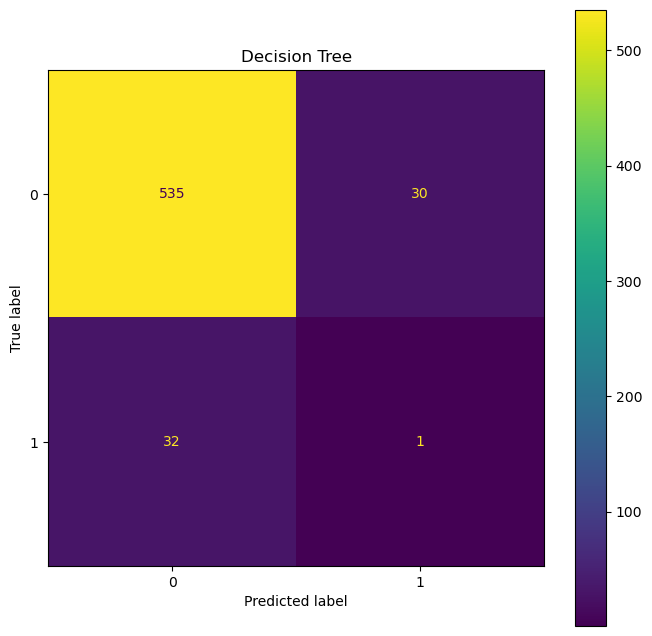

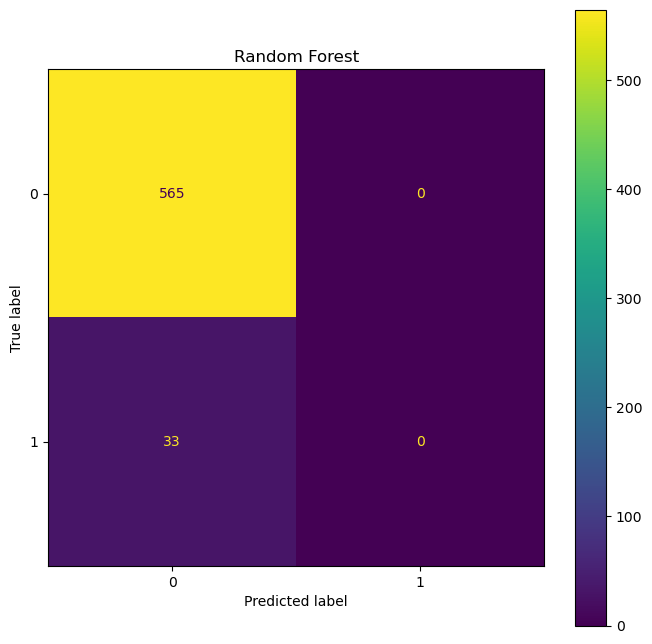

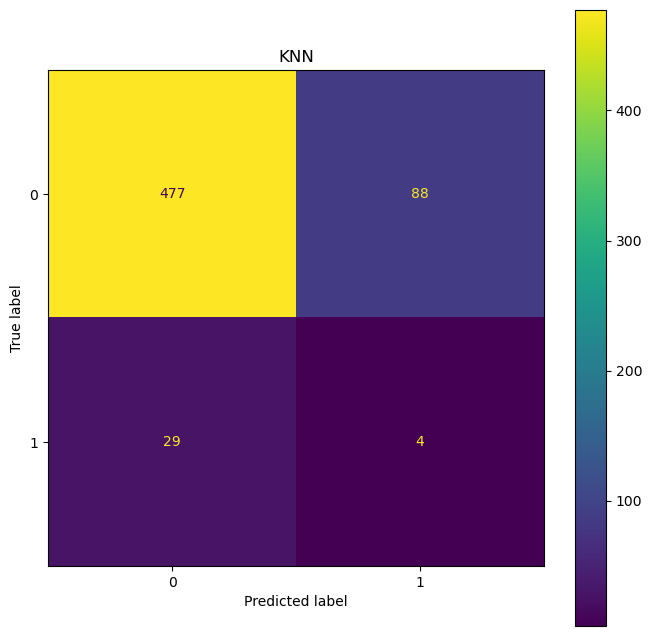

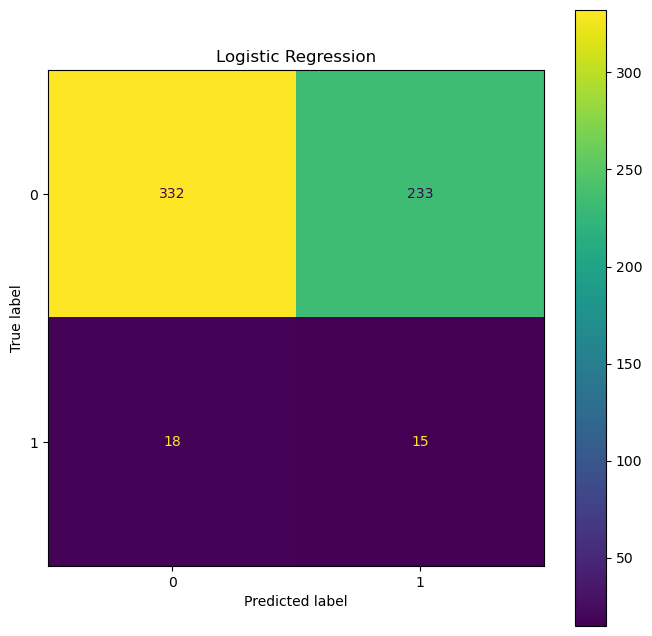

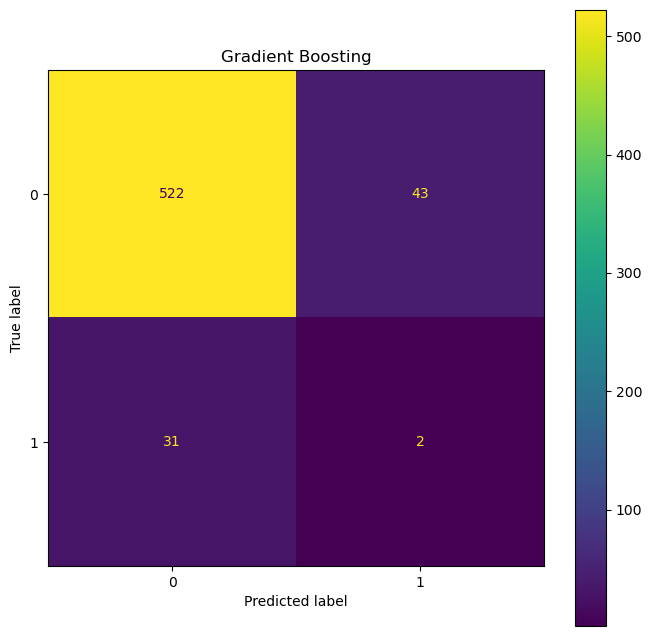

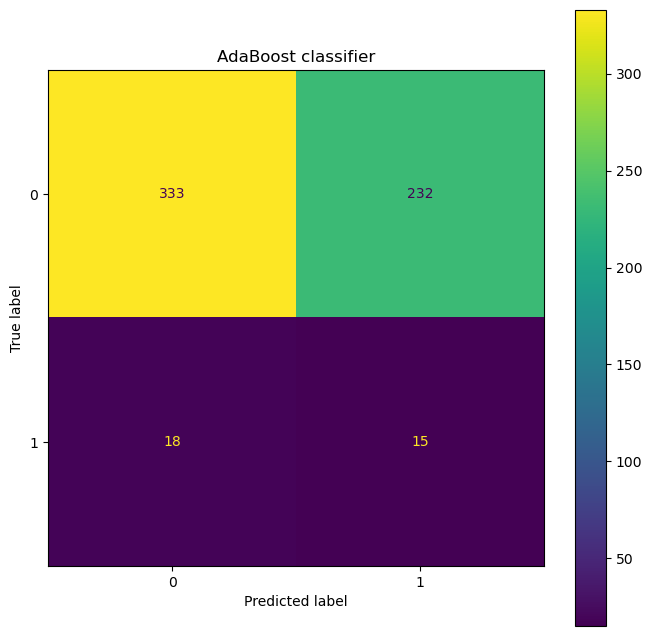

In [53]:
for name, y_pred in models.items():
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    vis.plot()
    plt.title(name)
    plt.show()

## Hyperperameter Tuning

Using GridSearchCV to tune the Logistic Regression, KNN, and AdaBoostClassifier models
    
    As they had the most promising results for recall (KNN didn't do better than dummy but still better than the tree-based models)

Using GridSearchCV instead of RandomizedSearchCV due to preliminary efforts not being fruitfull, I have a small hope that the randomsearch just didn't pick the actual best hyperperameters

### Tuning KNN

In [54]:
clf_knn = KNeighborsClassifier()

In [55]:
# use a full grid over all parameters
param_grid = {"n_neighbors": list(range(5, 100)), "weights": ['uniform', 'distance']}

# run grid search
grid_search = GridSearchCV(clf_knn, param_grid=param_grid, cv=5, scoring=['accuracy', 'recall'], refit='recall')

grid_search.fit(X, y['diagnosis']) #so y is passed as 1D array

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                         26, 27, 28, 29, 30, 31, 32, 33, 34, ...],
                         'weights': ['uniform', 'distance']},
             refit='recall', scoring=['accuracy', 'recall'])

In [56]:
pd.DataFrame(grid_search.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189
mean_fit_time,0.002602,0.002602,0.002002,0.002602,0.003304,0.003203,0.002803,0.002602,0.002803,0.003003,0.002803,0.002602,0.002402,0.002002,0.002202,0.002602,0.002802,0.002202,0.002202,0.002202,0.002703,0.002303,0.002403,0.002202,0.002403,0.002703,0.002402,0.002803,0.002402,0.002602,0.002704,0.002602,0.002402,0.002402,0.002602,0.002503,0.002402,0.002202,0.002302,0.002503,0.002002,0.002304,0.002403,0.002202,0.002402,0.002402,0.002202,0.002202,0.002402,0.002001,0.002202,0.002403,0.002402,0.002202,0.002202,0.002603,0.002602,0.002303,0.002402,0.002202,0.002603,0.002202,0.002402,0.002402,0.002402,0.002402,0.002202,0.002503,0.002402,0.002603,0.002503,0.002703,0.002602,0.002603,0.002303,0.002402,0.002402,0.002503,0.002002,0.002503,0.002202,0.002202,0.002602,0.002202,0.002002,0.002603,0.002402,0.002202,0.002002,0.002402,0.002402,0.002202,0.002002,0.002002,0.002002,0.002202,0.002202,0.002402,0.002203,0.002603,0.002603,0.002603,0.002802,0.003003,0.002402,0.002603,0.002402,0.002002,0.002602,0.002602,0.002402,0.002303,0.002202,0.002002,0.002402,0.002202,0.002102,0.002202,0.002302,0.002402,0.002202,0.002602,0.002803,0.002103,0.002002,0.002202,0.002202,0.002002,0.002102,0.002002,0.002202,0.002202,0.002402,0.002603,0.002002,0.002602,0.002852,0.002402,0.002402,0.002402,0.002403,0.002402,0.002402,0.002602,0.002202,0.002202,0.002002,0.001902,0.002202,0.002402,0.002402,0.002002,0.002202,0.002202,0.002402,0.002303,0.002803,0.002202,0.002402,0.003003,0.003804,0.003002,0.002402,0.002402,0.003003,0.003407,0.003203,0.003203,0.003604,0.002602,0.002802,0.002602,0.003003,0.002202,0.002202,0.002403,0.002602,0.003003,0.002603,0.002403,0.002402,0.002002,0.002402,0.002002,0.002002,0.002202,0.002503,0.002202,0.002303,0.002102
std_fit_time,0.00049,0.000491,0.0,0.00049,0.000602,0.0004,0.000749,0.00049,0.000749,0.000633,0.000749,0.00049,0.00049,0.0,0.0004,0.00049,0.0004,0.0004,0.0004,0.000401,0.0004,0.000401,0.00049,0.0004,0.00049,0.000601,0.000491,0.000399,0.00049,0.00049,0.000602,0.00049,0.00049,0.00049,0.00049,0.000447,0.00049,0.0004,0.000401,0.000448,0.0,0.000603,0.00049,0.000401,0.00049,0.00049,0.000401,0.0004,0.00049,0.0,0.0004,0.000375,0.000491,0.0004,0.0004,0.00049,0.000491,0.0004,0.000491,0.0004,0.000491,0.000401,0.00049,0.00049,0.000491,0.000491,0.0004,0.000448,0.00049,0.000491,0.000448,0.0004,0.000491,0.000491,0.000401,0.00049,0.000491,0.000447,0.0,0.000634,0.0004,0.0004,0.00049,0.0004,0.0,0.00049,0.000491,0.0004,0.0,0.00049,0.000491,0.0004,0.0,0.0,0.0,0.0004,0.000401,0.00049,0.000401,0.000491,0.00049,0.000491,0.0004,0.000633,0.00049,0.000491,0.00049,0.0,0.00049,0.000801,0.000491,0.0004,0.0004,0.0,0.00049,0.0004,0.000201,0.0004,0.0004,0.000491,0.0004,0.00049,0.0004,0.000202,0.000001,0.0004,0.000401,0.0,0.000201,0.0,0.0004,0.000401,0.000491,0.000801,0.0,0.00049,0.000701,0.00049,0.00049,0.00049,0.00049,0.00049,0.000491,0.00049,0.0004,0.0004,0.0,0.0002,0.0004,0.000491,0.00049,0.0,0.0004,0.0004,0.00049,0.0006,0.0004,0.0004,0.00049,0.000633,0.000749,0.000001,0.00049,0.000491,0.0,0.000805,0.0004,0.0004,0.000491,0.00049,0.000749,0.00049,0.000001,0.0004,0.000401,0.00049,0.000491,0.0,0.000491,0.000491,0.00049,0.0,0.000491,0.0,0.0,0.0004,0.000447,0.0004,0.000401,0.0002
mean_score_time,0.094592,0.030529,0.051098,0.033833,0.059457,0.039454,0.055154,0.033633,0.058355,0.033432,0.055524,0.032832,0.049046,0.030228,0.05155,0.032

In [57]:
print('Best parameters:', grid_search.best_params_)
print('Best recall score:', grid_search.best_score_)
print(grid_search.best_estimator_)

Best parameters: {'n_neighbors': 5, 'weights': 'uniform'}
Best recall score: 0.0
KNeighborsClassifier()


### Tuning Logistic Regression

In [58]:
clf_logr = LogisticRegression(random_state=9)

In [59]:
# specify parameters and distributions to sample from
param_dist = {"random_state": [9], 'max_iter' : [500], 'class_weight' : [None, 'balanced'], 'solver' : ['lbfgs', 'liblinear']}

# run grid search
grid_search = GridSearchCV(clf_logr, param_grid=param_dist, cv=5, scoring=['accuracy', 'recall'], refit='recall')

grid_search.fit(X, y['diagnosis']) #so y is passed as 1D array

#print("GridSearchCV for %d candidate parameter settings." % (len(grid_search.cv_results_["params"])))
#report(grid_search.cv_results_)

E:\Apps\Python\Anaconda\envs\Springboard\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=9),
             param_grid={'class_weight': [None, 'balanced'], 'max_iter': [500],
                         'random_state': [9],
                         'solver': ['lbfgs', 'liblinear']},
             refit='recall', scoring=['accuracy', 'recall'])

In [60]:
pd.DataFrame(grid_search.cv_results_).T

,0,1,2,3
mean_fit_time,0.065659,0.013508,0.084746,0.011398
std_fit_time,0.005529,0.001078,0.007527,0.001073
mean_score_time,0.003595,0.003308,0.004051,0.003012
std_score_time,0.000808,0.000249,0.00064,0.000323
param_class_weight,None,None,balanced,balanced
param_max_iter,500,500,500,500
param_random_state,9,9,9,9
param_solver,lbfgs,liblinear,lbfgs,liblinear
params,"{'class_weight': None, 'max_iter': 500, 'random_state': 9, 'solver': 'lbfgs'}","{'class_weight': None, 'max_iter': 500, 'random_state': 9, 'solver': 'liblinear'}","{'class_weight': 'balanced', 'max_iter': 500, 'random_state': 9, 'solver': 'lbfgs'}","{'class_weight': 'balanced', 'max_iter': 500, 'random_state': 9, 'solver': 'liblinear'}"
split0_test_accuracy,0.947808,0.947808,0.578288,0.5762


In [61]:
print('Best parameters:', grid_search.best_params_)
print('Best recall score:', grid_search.best_score_)
print(grid_search.best_estimator_)

Best parameters: {'class_weight': 'balanced', 'max_iter': 500, 'random_state': 9, 'solver': 'liblinear'}
Best recall score: 0.42833333333333334
LogisticRegression(class_weight='balanced', max_iter=500, random_state=9,
                   solver='liblinear')


### Tuning AdaBoostClassifier

    Grid search of Adaboost with models: Logistic Regression, RandomForest
        RandomForestClassifier because I am curious if the weighting adjustments with Ada could help it at all, not expecting RandomForest to suddenly be the best model
        Not KNN because it deosn't support sample weights (as is the basis for Adaboost)

In [62]:
clf_ada = AdaBoostClassifier(random_state=9, algorithm='SAMME', n_estimators = 200)

# specify parameters and distributions to sample from
param_dist = {'learning_rate' : [i/10 for i in range(1, 20)], #making learning rate like that since range() requires int's not floats
    'estimator' : [LogisticRegression(class_weight = 'balanced', max_iter = 500, solver = 'liblinear'),
                    RandomForestClassifier(n_estimators=100)]}

# rpd.DataFrame(grid_search.cv_results_).Tun grid search
grid_search = GridSearchCV(clf_ada, param_grid=param_dist, cv=5, scoring=['accuracy', 'recall'], refit='recall')
#start = time()
grid_search.fit(X, y['diagnosis']) #so y is passed as 1D array

#print("GridSearchCV for %d candidate parameter settings." % (len(grid_search.cv_results_["params"])))
#report(grid_search.cv_results_)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(algorithm='SAMME', n_estimators=200,
                                          random_state=9),
             param_grid={'estimator': [LogisticRegression(class_weight='balanced',
                                                          max_iter=500,
                                                          solver='liblinear'),
                                       RandomForestClassifier()],
                         'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                           0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4,
                                           1.5, 1.6, 1.7, 1.8, 1.9]},
             refit='recall', scoring=['accuracy', 'recall'])

In [63]:
pd.DataFrame(grid_search.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
mean_fit_time,0.408626,0.088516,0.060403,0.043261,0.03979,0.036691,0.023963,0.023648,0.025552,0.021952,0.027911,0.02663,0.038719,0.030581,0.037586,0.03456,0.036539,0.031093,0.0561,0.44872,0.448455,0.439008,0.471047,0.449113,0.442109,0.439368,0.442546,0.440195,0.452819,0.449562,0.483922,0.447627,0.441836,0.443056,0.441295,0.445679,0.445168,0.452444
std_fit_time,0.300955,0.021039,0.013255,0.006504,0.007453,0.011985,0.006033,0.00469,0.005446,0.007728,0.00915,0.008145,0.01592,0.004105,0.011708,0.013224,0.012242,0.007941,0.037085,0.012578,0.009278,0.01436,0.030718,0.015231,0.008243,0.012962,0.008842,0.01087,0.023742,0.018888,0.025231,0.013903,0.01411,0.009042,0.009849,0.008797,0.008468,0.010984
mean_score_time,0.011021,0.004712,0.003799,0.003808,0.004138,0.004611,0.003706,0.003812,0.003815,0.004237,0.004529,0.003917,0.004207,0.004316,0.003905,0.00392,0.003808,0.003408,0.004008,0.01082,0.01102,0.010337,0.011179,0.011746,0.010047,0.010097,0.010489,0.009918,0.010695,0.011143,0.01247,0.010886,0.010635,0.010786,0.010348,0.010649,0.010521,0.010768
std_score_time,0.005796,0.001028,0.000526,0.000683,0.000813,0.001468,0.000399,0.000244,0.000402,0.000744,0.000616,0.000175,0.00051,0.000819,0.001114,0.000599,0.000392,0.000376,0.000899,0.00088,0.000447,0.00023,0.000774,0.0011,0.000608,0.000563,0.000269,0.000488,0.000528,0.000766,0.000646,0.000372,0.000509,0.00039,0.000401,0.000707,0.000658,0.000497
param_estimator,"LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')","LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')",RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier(),RandomForestClassifier()
param_learning_rate,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9
params,"{'estimator': LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear'), 'learning_rate': 0.1}","{'estimator': LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear'), 'learning_rate': 0.2}","{'estimator': LogisticRegression(class_weight='balanced', max_iter

In [64]:
print('Best parameters:', grid_search.best_params_)
print('Best recall score:', grid_search.best_score_)
print(grid_search.best_estimator_)

Best parameters: {'estimator': LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear'), 'learning_rate': 0.1}
Best recall score: 0.46066666666666667
AdaBoostClassifier(algorithm='SAMME',
                   estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=500,
                                                solver='liblinear'),
                   learning_rate=0.1, n_estimators=200, random_state=9)


# Model Conclusions:

- Highest accuracy:
    - Random Forest
    - 94%
- Highest Precision (diagnosis=0):
    - KNN & Logistic-Regression
    - 95%
- Highest Precision (diagnosis=1):
    - Logistic-Regression
    - 7%
- Highest f1-score (diagnosis=0):
    - Random Forest
    - 0.97
- Highest f1-score (diagnosis=1):
    - Logistic Regression
    - 0.97
- Recall Scores: (for diag=1)
    - Decision Tree
        - 3%
    - Random Forest
        - 0%
    - KNN
        - 12%
    - Logistic Regression
        - 45%
    - Gradient Boosting
        - 6%
    - AdaBoost (LogisticRegression)
        - 45%
    - KNN (tuned with grid_search)
        - 0%
    - Logistic Regression (tuned with grid_search)
        - 43%
    - AdaBoost (tuned with grid_search)
        - 46%
        - Best parameters: {'estimator': LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear'), 'learning_rate': 0.1}

Overall I would choose the tuned AdaBoost model (with parameters listed above) due to it having the highest sensitivity (recall score). This model would be used essentially as a screening tool for real diagnostic testing. Having healthy patients go through testing and finding out they have a negative diagnosis is preferable to patients with the condition being innaccurately non-diagnosed.

There is a lot of room for improvement in this model and dataset.
If possible, more samples (especially for diagnosis=1 samples) would potentially improve predictions &/or detect relationships between features & target.

Done ~~Hyperperameter tuning should be a next step. I'd like to also compare a tuned KNN model alongside a tuned Logistic Regression model since the KNN was able to at least predict a few correct diagnosis=1 samples~~

No model was able to achieve greater than a 46% recall, well below the goal of 90% recall. Attempting other models may have better results but I have doubts on achieving the 90% goal from no models resulting in above 50% sensitivity.

A possible improvement could include more nuanced feature engineering but as of yet I have not detected relationships between features that could be exploited.

    (excluding more samples from the original study and attempting other classification models).